In [1]:
# Load model from file
import pickle
 
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [2]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('omw-1.4')
nltk.download('wordnet') 
nltk.download('wordnet2022')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('english'))

def process_texts(text):

    # Strip and convert text to lower case
    text = text.strip().lower()

    # Remove urls
    text = re.sub(r'http\S+', '', text)
    
    # Remove escape characters
    text = re.sub(r'\@\w+', '', text)

    # Remove emojis
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(emoji, '', text)

    # Remove html tags 
    text = re.sub(r'<.*?>', '', text)
    
    # Remove new line in string form
    text = re.sub(r'\\n', '', text)

    # Replace brackets with space
    text = re.sub(r'[\]\[\)\(]', ' ', text)
    
    # Remove all characters except alphabets
    text = re.sub(r'[^A-Za-z]' ,' ', text)

    # Replace multiple whitespace with single space
    text = re.sub(r'\s\s+', ' ', text)

    # Tokenize the sentence
    tokens = word_tokenize(text)

    # Remove stop words
    tokens = [t for t in tokens if not t in stop_words]

    # POS tag the words
    pos = pos_tag(tokens)

    # Lemmatize all words
    text = []
    for word, tag in pos:
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        text.append(lemmatizer.lemmatize(word, wntag) if wntag else word)

    # Remove single letter words
    for w in text:
        if len(w) <= 1:
            text.remove(w)

    return ' '.join(text)

[nltk_data] Downloading package omw-1.4 to /home/brian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/brian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to
[nltk_data]     /home/brian/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!
[nltk_data] Downloading package punkt to /home/brian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/brian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/brian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
import pandas as pd

def predict_stress(text):
    predicted_label = model.predict([text])[0] 
    return predicted_label

def predict_stress_reddit(df_reddit):
    df_reddit = df_reddit[['selftext', 'created']]
    df_reddit = df_reddit.dropna()

    df_reddit['created'] = df_reddit['created'].astype(int)
    df_reddit['created_time'] = pd.to_datetime(df_reddit['created'], unit='s')

    # Process texts
    df_reddit['processed_text'] = df_reddit['selftext'].apply(lambda x : process_texts(x))

    # Remove posts that are too short
    df_reddit = df_reddit[df_reddit['processed_text'].apply(lambda x: len(x.split()) >= 10)]

    # Predict stress
    df_reddit['stress'] = df_reddit['processed_text'].apply(lambda x : predict_stress(x))

    return df_reddit

def predict_stress_reddit_comments(df_reddit):
    df_reddit = df_reddit[['body', 'created']]
    df_reddit = df_reddit.dropna()

    df_reddit['created'] = df_reddit['created'].astype(int)
    df_reddit['created_time'] = pd.to_datetime(df_reddit['created'], unit='s')

    # Process texts
    df_reddit['processed_text'] = df_reddit['body'].apply(lambda x : process_texts(x))

    # Remove posts that are too short
    df_reddit = df_reddit[df_reddit['processed_text'].apply(lambda x: len(x.split()) >= 10)]

    # Predict stress
    df_reddit['stress'] = df_reddit['processed_text'].apply(lambda x : predict_stress(x))

    return df_reddit

In [212]:
df_usyd_s = predict_stress_reddit(pd.read_json('datasets/reddit/usyd_submissions.zip', lines=True))
df_usyd_c = predict_stress_reddit_comments(pd.read_json('datasets/reddit/usyd_comments.zip', lines=True))
df_usyd = pd.concat([df_usyd_s, df_usyd_c])

In [26]:
df_unimelb_s = predict_stress_reddit(pd.read_json('datasets/reddit/unimelb_submissions.zip', lines=True))
df_unimelb_c = predict_stress_reddit_comments(pd.read_json('datasets/reddit/unimelb_comments.zip', lines=True))
df_unimelb = pd.concat([df_unimelb_s, df_unimelb_c])

In [211]:
df_UQ_s = predict_stress_reddit(pd.read_json('datasets/reddit/UQreddit_submissions.zip', lines=True))
df_UQ_c = predict_stress_reddit_comments(pd.read_json('datasets/reddit/UQreddit_comments.zip', lines=True))
df_UQ = pd.concat([df_UQ_s, df_UQ_c])

In [213]:
df_unsw_s = predict_stress_reddit(pd.read_json('datasets/reddit/unsw_submissions.zip', lines=True))
df_unsw_c = predict_stress_reddit_comments(pd.read_json('datasets/reddit/unsw_comments.zip', lines=True))
df_unsw = pd.concat([df_unsw_s, df_unsw_c])

In [10]:
df_ubc_s = predict_stress_reddit(pd.read_json('datasets/reddit/UBC_submissions.zst', lines=True))
df_ubc_c = predict_stress_reddit_comments(pd.read_json('datasets/reddit/UBC_comments.zst', lines=True))
df_ubc = pd.concat([df_ubc_s, df_ubc_c])

In [189]:
df_sfu_submissions = predict_stress_reddit(pd.read_json('datasets/reddit/simonfraser/simonfraser_submissions.zip', lines=True))
df_sfu_comments = predict_stress_reddit_comments(pd.read_json('datasets/reddit/simonfraser/simonfraser_comments.zip', lines=True))
df_sfu_scraped = predict_stress_reddit(pd.read_csv('datasets/reddit/simonfraser/simonfraser.csv'))
df_sfu = pd.concat([df_sfu_submissions, df_sfu_comments, df_sfu_scraped])

In [14]:
df_uoft = predict_stress_reddit(pd.read_json('datasets/reddit/UofT_submissions.zip', lines=True))

In [ ]:
df_ubc = predict_stress_reddit(pd.read_json('datasets/reddit/ubco_submissions.zip', lines=True))

In [ ]:
df_stress = predict_stress_reddit(pd.read_json('datasets/reddit/Stress_submissions.zip', lines=True))

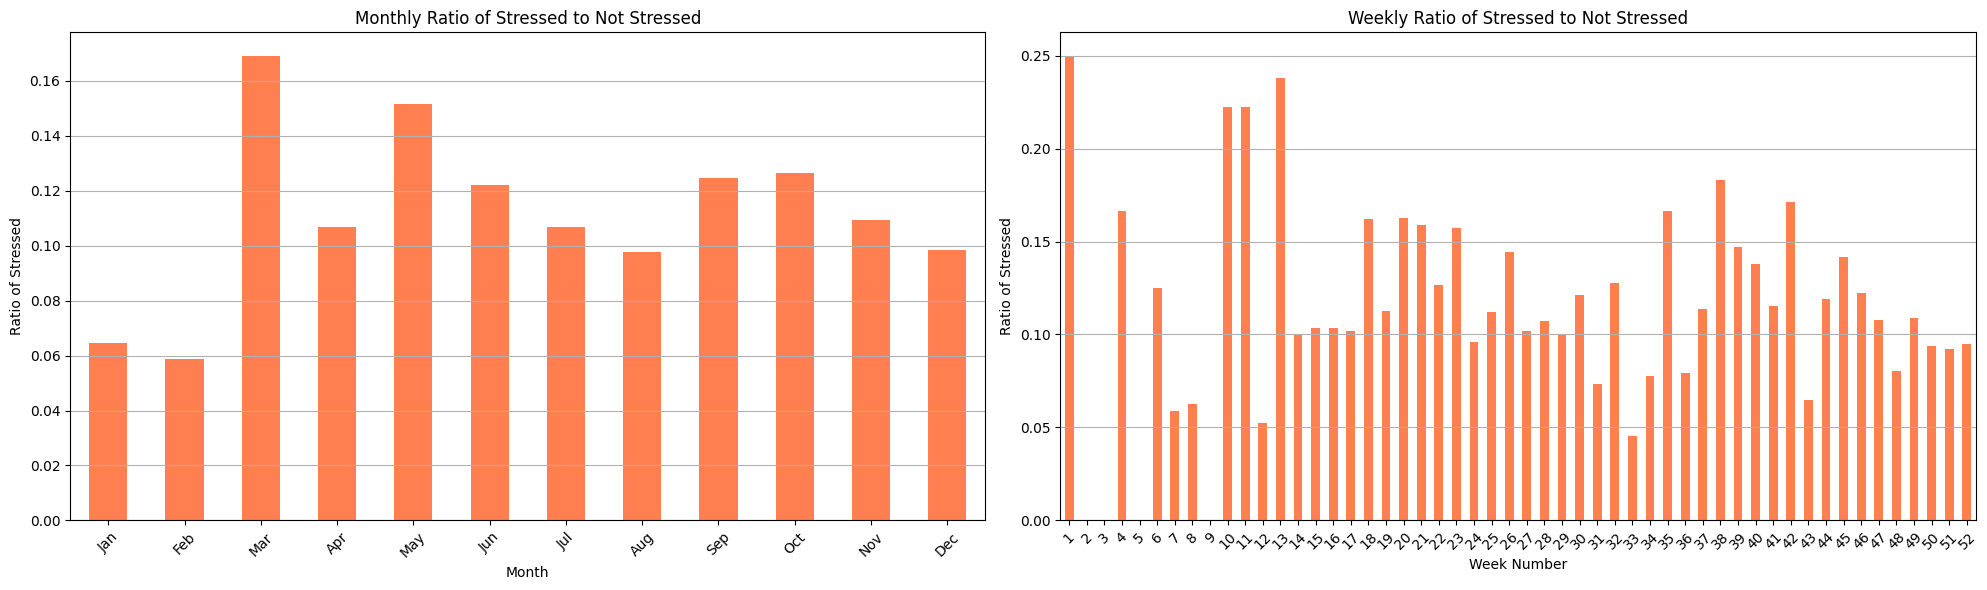

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_monthly_stress_ratio(df, ax):
    df['month'] = df['created_time'].dt.month

    monthly_counts = df.groupby('month').stress.value_counts().unstack(fill_value=0)
    monthly_counts['ratio'] = monthly_counts[1] / (monthly_counts[0] + monthly_counts[1])
    monthly_counts = monthly_counts.sort_index()
    monthly_counts['ratio'].plot(kind='bar', color='coral', ax=ax)

    ax.set_xlabel('Month')
    ax.set_ylabel('Ratio of Stressed')
    ax.set_title('Monthly Ratio of Stressed to Not Stressed')
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
    ax.grid(axis='y')
    ax.set_ylim(top=1)


def plot_weekly_stress_ratio(df, ax):
    df['week'] = df['created_time'].dt.isocalendar().week

    weekly_counts = df.groupby('week').stress.value_counts().unstack(fill_value=0)
    weekly_counts['ratio'] = weekly_counts[1] / (weekly_counts[0] + weekly_counts[1])
    weekly_counts = weekly_counts.sort_index()
    weekly_counts['ratio'].plot(kind='bar', color='coral', ax=ax)

    ax.set_xlabel('Week Number')
    ax.set_ylabel('Ratio of Stressed')
    ax.set_title('Weekly Ratio of Stressed to Not Stressed')
    
    ax.set_xticks(range(len(weekly_counts.index)))
    ax.set_xticklabels([str(week) for week in weekly_counts.index], rotation=45)
    ax.grid(axis='y')
    
fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

plot_monthly_stress_ratio(df_usyd, axs[0])
plot_weekly_stress_ratio(df_usyd, axs[1])

plt.tight_layout()
plt.show()


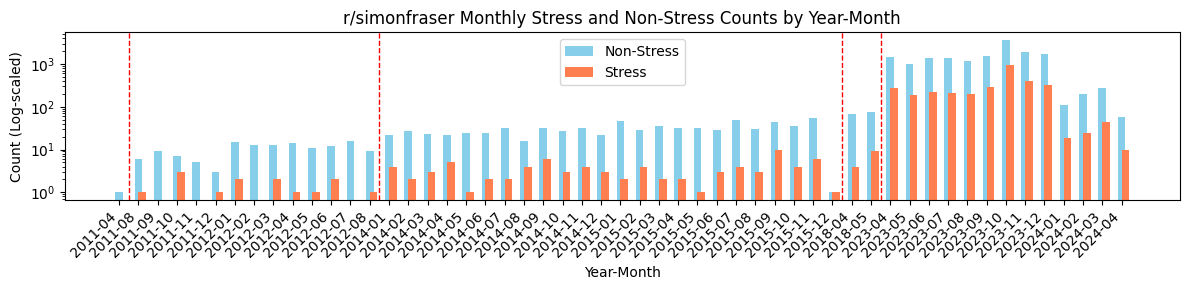

In [126]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_timeline(df):
    df['created_time'] = pd.to_datetime(df['created_time'])

    df['year'] = df['created_time'].dt.year
    df['month'] = df['created_time'].dt.month

    grouped_data = df.groupby(['year', 'month', 'stress']).size().unstack(fill_value=0)
    grouped_data.columns = ['Non-Stress', 'Stress']
    grouped_data.reset_index(inplace=True)

    all_months = pd.date_range(start=df['created_time'].min(), end=df['created_time'].max(), freq='MS').tolist()
    all_months = [(date.year, date.month) for date in all_months]

    present_months = set((row['year'], row['month']) for index, row in grouped_data.iterrows())

    filtered_data = grouped_data[grouped_data.apply(lambda x: (x['year'], x['month']) in present_months, axis=1)]

    fig, ax = plt.subplots(figsize=(12, 3))
    x = np.arange(len(filtered_data))
    ax.bar(x, filtered_data['Non-Stress'], width=0.4, label='Non-Stress', align='center', color='skyblue')
    ax.bar(x, filtered_data['Stress'], width=0.4, label='Stress', align='edge', color='coral')
    ax.set_yscale('log')
    ax.set_xlabel('Year-Month')
    ax.set_ylabel('Count (Log-scaled)')
    ax.set_title('r/simonfraser Monthly Stress and Non-Stress Counts by Year-Month')
    ax.set_xticks(x)
    ax.set_xticklabels(['{}-{:02d}'.format(year, month) for year, month in zip(filtered_data['year'], filtered_data['month'])], rotation=45, ha="right")

    ax.legend()

    curr_idx = 0
    last_idx = 0  
    for idx, (year, month) in enumerate(all_months):
        if (year, month) not in present_months:
            if last_idx >= 0:  
                ax.axvline(x=last_idx + 0.5, color='red', linestyle='--', linewidth=1)
                last_idx = -1  
        else:
            curr_idx = curr_idx + 1
            last_idx = curr_idx 

    plt.tight_layout()
    plt.savefig('demo.png', transparent=True,bbox_inches='tight')
    plt.show()

visualize_timeline(df_sfu)

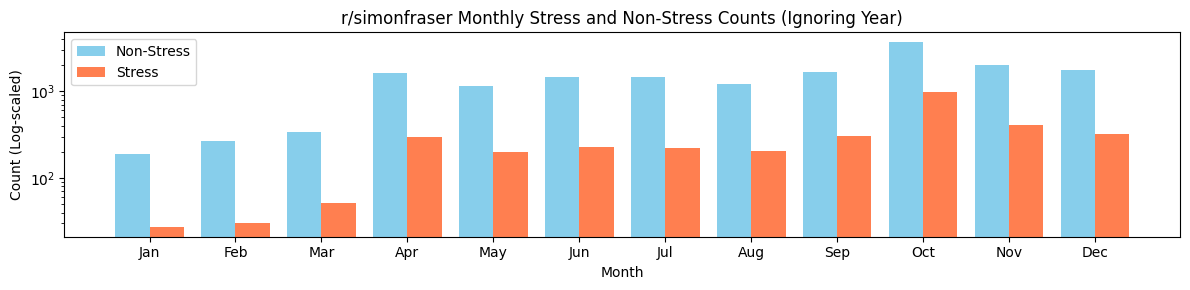

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def visualize_timeline_year(df):
    df['created_time'] = pd.to_datetime(df['created_time'])

    df['month'] = df['created_time'].dt.month

    monthly_data = df.groupby('month')['stress'].value_counts().unstack(level=1).fillna(0)
    monthly_data.columns = ['Non-Stress', 'Stress']

    fig, ax = plt.subplots(figsize=(12, 3))
    x = np.arange(1, 13)  # 1 through 12 for each month
    ax.bar(x - 0.2, monthly_data['Non-Stress'], width=0.4, label='Non-Stress', align='center', color='skyblue')
    ax.bar(x + 0.2, monthly_data['Stress'], width=0.4, label='Stress', align='center', color='coral')

    ax.set_yscale('log')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count (Log-scaled)')
    ax.set_title('r/simonfraser Monthly Stress and Non-Stress Counts (Ignoring Year)')
    ax.set_xticks(x)
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.legend()

    plt.tight_layout()
    plt.savefig('demo.png', transparent=True,bbox_inches='tight')
    plt.show()

visualize_timeline_year(df_sfu)

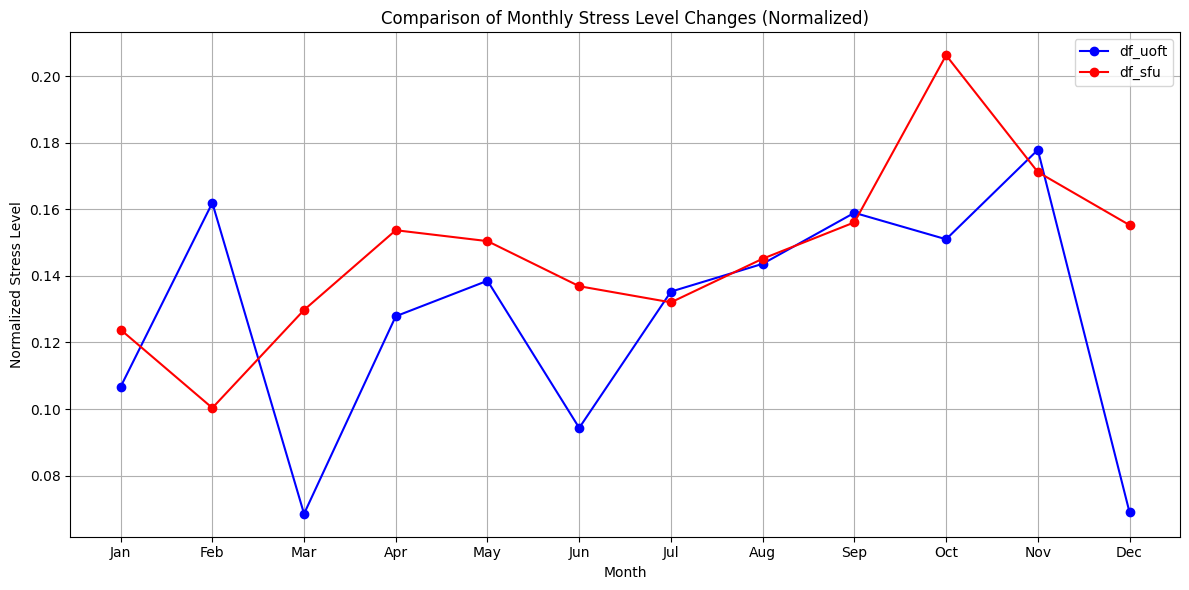

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def normalize_monthly_stress(df):
    df['month'] = df['created_time'].dt.month

    monthly_stress_mean = df.groupby('month')['stress'].mean()
    scaler = MinMaxScaler()
    monthly_stress_normalized = scaler.fit_transform(monthly_stress_mean.values.reshape(-1, 1)).flatten()

    return monthly_stress_normalized

def compare_monthly_stress_changes(df1, df2):
    # Normalize monthly stress for both dataframes
    normalized_stress_df1 = normalize_monthly_stress(df1)
    normalized_stress_df2 = normalize_monthly_stress(df2)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 13), normalized_stress_df1, marker='o', linestyle='-', color='blue', label='df_uoft')
    plt.plot(range(1, 13), normalized_stress_df2, marker='o', linestyle='-', color='red', label='df_sfu')

    # Formatting the plot
    plt.xlabel('Month')
    plt.ylabel('Normalized Stress Level')
    plt.title('Comparison of Monthly Stress Level Changes (Normalized)')
    plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

compare_monthly_stress_changes(df_ubc, df_sfu)


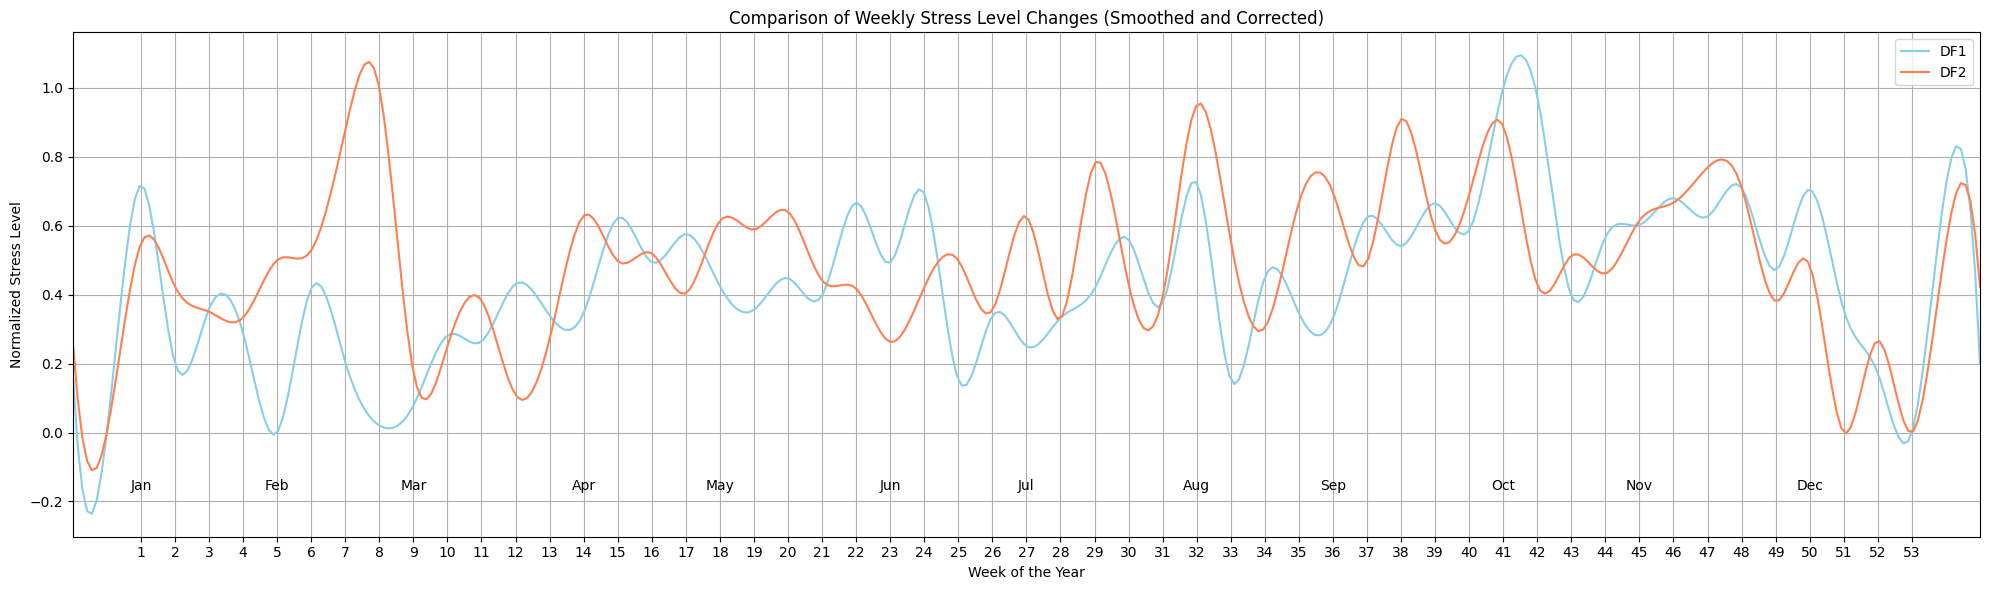

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline

def normalize_weekly_stress(df):
    df['week'] = df['created_time'].dt.isocalendar().week
    weekly_stress_mean = df.groupby('week')['stress'].mean()
    scaler = MinMaxScaler()
    weekly_stress_normalized = np.zeros(53)
    normalized_values = scaler.fit_transform(weekly_stress_mean.values.reshape(-1, 1)).flatten()
    weekly_stress_normalized[weekly_stress_mean.index - 1] = normalized_values
    return weekly_stress_normalized

def extend_and_smooth_plot_weeks(x, y):
    x_extended = np.concatenate(([-1, 0], x, [54, 55]))
    y_extended = np.concatenate(([y[-2], y[-1]], y, [y[0], y[1]]))
    
    x_smooth = np.linspace(x_extended.min(), x_extended.max(), 400)
    y_smooth = make_interp_spline(x_extended, y_extended)(x_smooth)
    return x_smooth, y_smooth

def compare_weekly_stress_changes_corrected(df1, df2):
    normalized_stress_df1 = normalize_weekly_stress(df1)
    normalized_stress_df2 = normalize_weekly_stress(df2)

    weeks = np.arange(1, 54) 

    weeks_smooth_df1, stress_smooth_df1 = extend_and_smooth_plot_weeks(weeks, normalized_stress_df1)
    weeks_smooth_df2, stress_smooth_df2 = extend_and_smooth_plot_weeks(weeks, normalized_stress_df2)

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(weeks_smooth_df1, stress_smooth_df1, linestyle='-', color='skyblue', label='DF1')
    ax.plot(weeks_smooth_df2, stress_smooth_df2, linestyle='-', color='coral', label='DF2')

    ax.set_xlabel('Week of the Year')
    ax.set_ylabel('Normalized Stress Level')
    ax.set_title('Comparison of Weekly Stress Level Changes (Smoothed and Corrected)')
    ax.set_xticks(np.arange(1, 54))


    month_starts = [1, 5, 9, 14, 18, 23, 27, 32, 36, 41, 45, 50] 
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for month_start, month_name in zip(month_starts, month_names):
        ax.annotate(month_name, xy=(month_start, 0.1), xycoords=('data', 'axes fraction'), ha='center', va='center')

    ax.legend()
    ax.grid(True)

    plt.xlim(-1, 55)

    plt.tight_layout()
    plt.show()


compare_weekly_stress_changes_corrected(df_sfu, df_ubc)


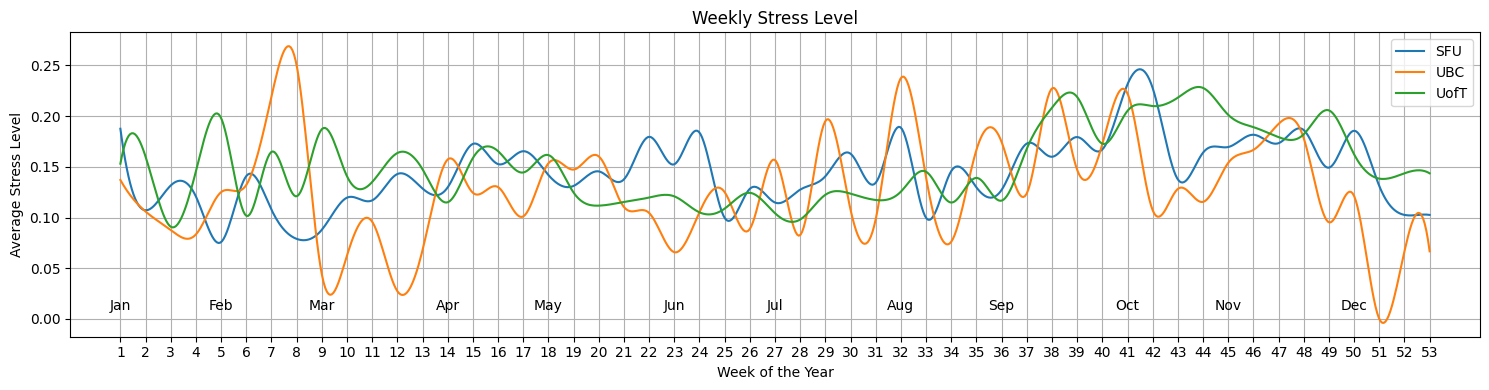

In [218]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

def calculate_weekly_stress(df):
    df['week'] = df['created_time'].dt.isocalendar().week
    weekly_stress_mean = df.groupby('week')['stress'].mean()

    return weekly_stress_mean

def smooth_plot_weeks(x, y):
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    
    x_smooth = np.linspace(x_sorted.min(), x_sorted.max(), 800)
    spline = make_interp_spline(x_sorted, y_sorted, k=3) 
    y_smooth = spline(x_smooth)
    #return x, y
    return x_smooth, y_smooth

def compare_weekly_stress_changes_direct(df_arr):
    plt.figure(figsize=(15, 4))
    all_weeks = np.arange(1, 54)
    for df, label in df_arr:
        weekly_stress_df = calculate_weekly_stress(df)
        all_weeks = np.arange(1, 54)

        stress_interpolated_df= np.interp(all_weeks, weekly_stress_df.index, weekly_stress_df.values)
        weeks_smooth_df, stress_smooth_df = smooth_plot_weeks(all_weeks, stress_interpolated_df)
        
        plt.plot(weeks_smooth_df, stress_smooth_df, linestyle='-', label=label)

    month_starts = [1, 5, 9, 14, 18, 23, 27, 32, 36, 41, 45, 50]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax = plt.gca()
    for month_start, month_name in zip(month_starts, month_names):
        ax.annotate(month_name, xy=(month_start, 0.1), xycoords=('data', 'axes fraction'), ha='center', va='center')



    plt.xlabel('Week of the Year')
    plt.ylabel('Average Stress Level')
    plt.title('Weekly Stress Level')
    plt.xticks(np.arange(1, 54, step=1), rotation=0) 
    
    plt.xlim(-1, 55)
    #plt.ylim(0,0.3)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('demo.png', transparent=True)
    plt.show()


compare_weekly_stress_changes_direct([(df_sfu, 'SFU'), (df_ubc, 'UBC'), (df_uoft, 'UofT')])


In [6]:
df_random = predict_stress_reddit(pd.read_json('datasets/reddit/RandomThoughts_submissions.zst', lines=True))

In [5]:
df_vancouver = predict_stress_reddit(pd.read_json('datasets/reddit/vancouver_submissions.zst', lines=True))

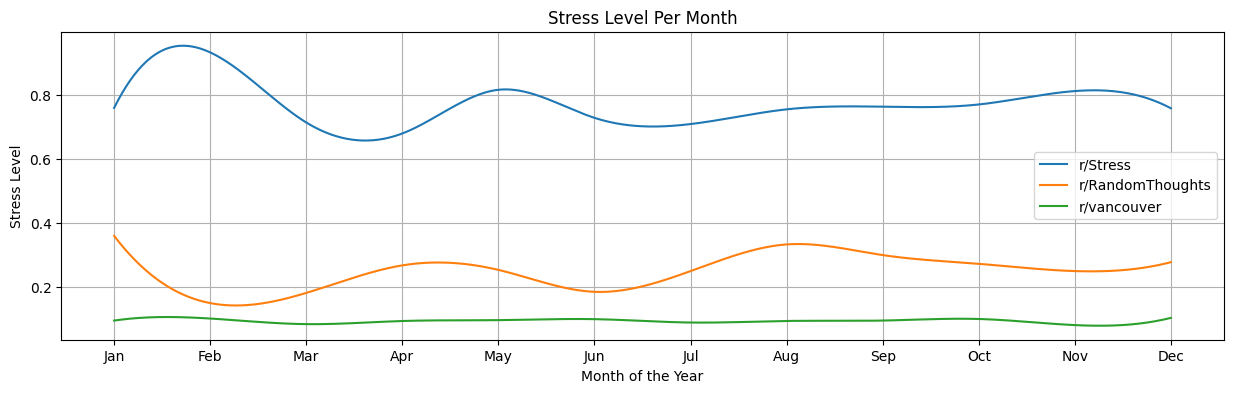

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def smooth_plot_months(x, y):
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    
    x_smooth = np.linspace(x_sorted.min(), x_sorted.max(), 800)
    spline = make_interp_spline(x_sorted, y_sorted, k=3)  # Using cubic spline
    y_smooth = spline(x_smooth)
    #return x, y
    return x_smooth, y_smooth

def plot_stress_level_per_month(df_arr):
    plt.figure(figsize=(15, 4))
    for df, label in df_arr:
        all_months = np.arange(1, 13)

        df['month'] = df['created_time'].dt.month
        monthly_stress = df.groupby('month')['stress'].mean()

        stress_interpolated_df = np.interp(all_months, monthly_stress.index, monthly_stress.values)
        months_smooth, stress_smooth = smooth_plot_months(all_months, stress_interpolated_df)
        plt.plot(months_smooth, stress_smooth, label=label)

    plt.title('Stress Level Per Month')
    plt.xlabel('Month of the Year')
    plt.ylabel('Stress Level')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend()
    plt.grid(True)
    plt.savefig('demo.png', transparent=True)
    plt.show()

plot_stress_level_per_month([(df_stress,'r/Stress'), (df_random, 'r/RandomThoughts'), (df_vancouver, 'r/vancouver')])
#plot_stress_level_per_month([(pd.concat([df_sfu, df_ubc, df_uoft]), 'Canadian Universities'), (pd.concat([df_unimelb, df_usyd, df_UQ, df_unsw]), 'Australian Universities')])